# AirBNB NYC Property Clustering - Modeling

## Springboard Data Science Track - Third Capstone - Travis Martin

In [217]:
# Loading necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from pandas.plotting import parallel_coordinates
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [218]:
# Loading pre-processed dataset from .csv to a Pandas Dataframe
df_NYC = pd.read_csv('D://Springboard/ThirdCapstone/RawData/preprocessed_df.csv')
df_NYC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16242 entries, 0 to 16241
Data columns (total 94 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   log_price                  16242 non-null  float64
 1   accommodates               16242 non-null  float64
 2   bathrooms                  16242 non-null  float64
 3   real_bed                   16242 non-null  int64  
 4   cancellation_policy        16242 non-null  int64  
 5   cleaning_fee               16242 non-null  int64  
 6   host_has_profile_pic       16242 non-null  int64  
 7   host_identity_verified     16242 non-null  int64  
 8   host_response_rate         16242 non-null  float64
 9   instant_bookable           16242 non-null  int64  
 10  latitude                   16242 non-null  float64
 11  longitude                  16242 non-null  float64
 12  number_of_reviews          16242 non-null  float64
 13  review_scores_rating       16242 non-null  flo

With 94 different features in our dataset, there could be some performance improvement achieved with feature reduction. We'll evaluate the effects of performing Principal Component Analysis on our data, and optimize the number of features using the knee/elbow method.

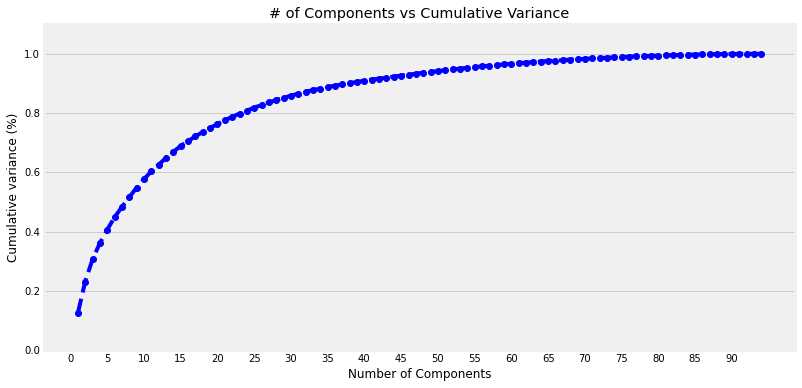

In [219]:
# Scaling data using MinMaxScaler, and fitting PCA() to the scaled result
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_NYC)
scaled_df = pd.DataFrame(scaled, columns = df_NYC.columns)
pca = PCA().fit(scaled_df)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 95, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 94, step=5)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('# of Components vs Cumulative Variance')

ax.grid(axis='x')
plt.show()

In [220]:
kl = KneeLocator(
   xi, y, curve="concave", direction="increasing")

kl.elbow

25

According to the KneeLocator tool, we start to see diminishing returns on additional features once we consider more than 25. We'll use 25 as our target n_components for performing the PCA.

In [221]:
pca = PCA(n_components=25).fit(scaled_df)

In [222]:
# Creating a pipeline object that will both scale and perform PCA on our data.
preprocessor = Pipeline([("scaler", MinMaxScaler()),("pca",PCA(n_components=25, random_state=42))])

In [223]:
preprocessor.fit(df_NYC)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=25, random_state=42))])

In [224]:
preprocessed_data = preprocessor.transform(df_NYC)

### Applying the K-Means Clustering algorithm

In [131]:
kmeans.fit(preprocessed_data)

KMeans(init='random', n_clusters=5, random_state=42)

In [132]:
kmeans.inertia_

48609.57738623029

In [133]:
kmeans.cluster_centers_

array([[ 1.08342649e+00, -2.83486357e-01, -1.11096812e-01,
        -1.29721634e-02, -8.40665273e-03, -1.56833578e-01,
         5.40285051e-02, -1.11639999e-01,  5.15699431e-02,
        -4.74658716e-02,  2.84356431e-03,  8.73165458e-02,
         5.49660243e-03, -2.59824237e-02,  5.14405222e-03,
         2.12469887e-02, -9.63444942e-03, -1.43962597e-03,
        -2.23864547e-02, -2.03011755e-02,  8.50532080e-03,
        -9.09872308e-04, -1.15491415e-03, -3.23645682e-02,
         3.39457283e-03],
       [-5.69370828e-01, -8.20835321e-01,  1.91718096e-01,
        -6.01906308e-02, -5.72012415e-02, -4.19282610e-02,
        -1.80511581e-03,  1.73335327e-02,  1.77396852e-03,
        -1.36826199e-02,  2.76883849e-02, -8.08104087e-02,
         1.35143302e-02,  2.11727898e-02,  7.31892046e-03,
        -3.23356001e-02,  1.69131042e-02,  3.31895148e-03,
         2.27417572e-02,  2.09756518e-02, -8.30064163e-03,
        -2.29037183e-03,  1.88294149e-03,  3.13738916e-02,
         5.55525235e-03],
    

In [134]:
kmeans.n_iter_

19

In [135]:
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}
# A list holds the SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(preprocessed_data)
    sse.append(kmeans.inertia_)

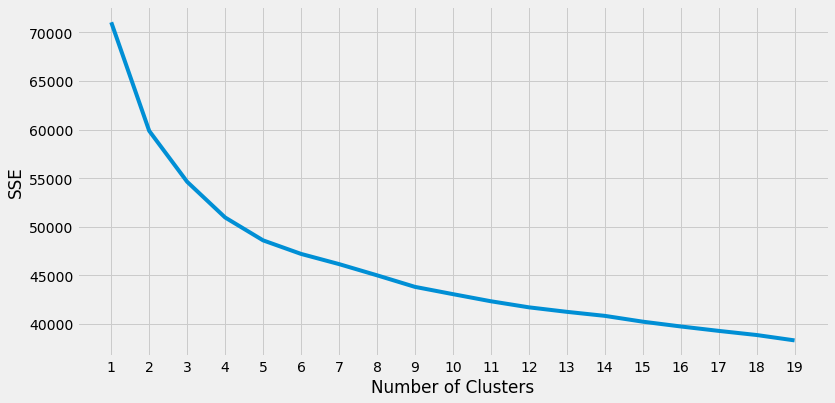

In [136]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [137]:
kl = KneeLocator(
   range(1, 20), sse, curve="convex", direction="decreasing")

kl.elbow


5

Based on the cluster vs SSE chart and KneeLocator, the optimal number of KMeans clusters is 5.

In [138]:
# Fitting KMeans with the optimal parameters to our preprocessed data
kmeans = KMeans(init='random', n_clusters=5, n_init=10, max_iter=300, random_state=42)
kmeans.fit(preprocessed_data)

KMeans(init='random', n_clusters=5, random_state=42)

In [139]:
labels = kmeans.labels_

In [140]:
preprocessed_data

array([[ 1.15609037, -0.34580738, -0.37427852, ...,  0.05630841,
        -0.03359882, -0.0449267 ],
       [-0.82542266,  0.216862  , -0.03445766, ..., -0.01913836,
        -0.01893237, -0.14680713],
       [-0.42381128, -0.6728287 ,  0.74222502, ..., -0.00577078,
        -0.00808295, -0.04704404],
       ...,
       [ 1.05311478, -0.70032016, -1.16938579, ..., -0.01771165,
        -0.08389347,  0.0130916 ],
       [ 0.5169983 ,  1.57764286,  0.10449889, ..., -0.19129   ,
         0.53835017,  0.07723724],
       [-0.85659722,  0.18186057,  0.1214313 , ...,  0.05246913,
        -0.00992953, -0.10338691]])

We see from the value counts below that clusters 0 and 1 are the largest, at 4.3k and 4.7k members respectively. Cluster 3 is the smallest with only 1.3k members.

In [141]:
scaled_df['Cluster'] = pd.Series(labels, index=scaled_df.index)
scaled_df['Cluster'].value_counts()

1    4734
0    4279
4    3471
2    2479
3    1279
Name: Cluster, dtype: int64

In [142]:
kmeans.cluster_centers_

array([[ 1.08342649e+00, -2.83486357e-01, -1.11096812e-01,
        -1.29721634e-02, -8.40665273e-03, -1.56833578e-01,
         5.40285051e-02, -1.11639999e-01,  5.15699431e-02,
        -4.74658716e-02,  2.84356431e-03,  8.73165458e-02,
         5.49660243e-03, -2.59824237e-02,  5.14405222e-03,
         2.12469887e-02, -9.63444942e-03, -1.43962597e-03,
        -2.23864547e-02, -2.03011755e-02,  8.50532080e-03,
        -9.09872308e-04, -1.15491415e-03, -3.23645682e-02,
         3.39457283e-03],
       [-5.69370828e-01, -8.20835321e-01,  1.91718096e-01,
        -6.01906308e-02, -5.72012415e-02, -4.19282610e-02,
        -1.80511581e-03,  1.73335327e-02,  1.77396852e-03,
        -1.36826199e-02,  2.76883849e-02, -8.08104087e-02,
         1.35143302e-02,  2.11727898e-02,  7.31892046e-03,
        -3.23356001e-02,  1.69131042e-02,  3.31895148e-03,
         2.27417572e-02,  2.09756518e-02, -8.30064163e-03,
        -2.29037183e-03,  1.88294149e-03,  3.13738916e-02,
         5.55525235e-03],
    

In [172]:
score = silhouette_score(preprocessed_data, kmeans.labels_, metric='euclidean')

print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.152


The silhouette score, which is an indicator of intra-cluster density and inter-cluster separatedness, is 0.152. With a scale of possible values between -1 and 1, this is an acceptably positive result. 

In [143]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16242 entries, 0 to 16241
Data columns (total 95 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   log_price                  16242 non-null  float64
 1   accommodates               16242 non-null  float64
 2   bathrooms                  16242 non-null  float64
 3   real_bed                   16242 non-null  float64
 4   cancellation_policy        16242 non-null  float64
 5   cleaning_fee               16242 non-null  float64
 6   host_has_profile_pic       16242 non-null  float64
 7   host_identity_verified     16242 non-null  float64
 8   host_response_rate         16242 non-null  float64
 9   instant_bookable           16242 non-null  float64
 10  latitude                   16242 non-null  float64
 11  longitude                  16242 non-null  float64
 12  number_of_reviews          16242 non-null  float64
 13  review_scores_rating       16242 non-null  flo

In [61]:
df_NYC.to_csv('D:/Springboard/ThirdCapstone/RawData/clusters_df.csv', index=False)

In [162]:
#data = []
#for a, b, c in some_function_that_yields_data():
#    data.append([a, b, c])

# mean_scaled = pd.DataFrame(data, columns=['A', 'B', 'C'])

col_list = scaled_df.columns.values.tolist()
values = ['mean'] * len(col_list)

dictionary = dict(zip(col_list, values))
print(dictionary) # {'a': 1, 'b': 2, 'c': 3}

scaled_means = scaled_df.groupby('Cluster').agg(dictionary)

{'log_price': 'mean', 'accommodates': 'mean', 'bathrooms': 'mean', 'real_bed': 'mean', 'cancellation_policy': 'mean', 'cleaning_fee': 'mean', 'host_has_profile_pic': 'mean', 'host_identity_verified': 'mean', 'host_response_rate': 'mean', 'instant_bookable': 'mean', 'latitude': 'mean', 'longitude': 'mean', 'number_of_reviews': 'mean', 'review_scores_rating': 'mean', 'zipcode': 'mean', 'bedrooms': 'mean', 'beds': 'mean', 'AC': 'mean', 'WiFi': 'mean', 'Office': 'mean', 'Kids': 'mean', 'Washer': 'mean', 'Dryer': 'mean', 'Elevator': 'mean', '24hr': 'mean', 'BR_Lock': 'mean', 'Self_CheckIn': 'mean', 'Pet_Friendly': 'mean', 'Doorman': 'mean', 'Private_Ent': 'mean', 'Stove': 'mean', 'Oven': 'mean', 'Gym': 'mean', 'Lockbox': 'mean', 'Free_parking': 'mean', 'Breakfast': 'mean', 'Wheelchair': 'mean', 'Pets_on_prop': 'mean', 'Events': 'mean', 'Fireplace': 'mean', 'Dishwasher': 'mean', 'Hot_tub': 'mean', 'Long_term': 'mean', 'Darkening': 'mean', 'Pets': 'mean', 'Luggage': 'mean', 'Smoking': 'mean',

In [163]:
df_text = scaled_means[['log_price', 'desc_length','name_length', '#_of_amenities', 'big_words', 'small_words', 'pub_trans_words', 'landmark_words', 'nightlife_words',  'business_words', 'safety_words', 'view_words', 'updates_words', 'cleanliness_words', 'tourism_words', 'relaxation_words', 'family_words', 'proximity_words', 'romance_words', 'luxury_words', 'culture_words', 'ease_words', 'hip_words', 'history_words', 'nature_words', 'retail_words', 'negative_words', 'Cluster']]

In [164]:
df_amenities = scaled_means[['log_price', 'AC', 'WiFi', 'Office', 'Kids', 'Washer', 'Dryer', 'Elevator', '24hr', 'BR_Lock', 'Self_CheckIn', 'Pet_Friendly', 'Doorman', 'Private_Ent', 'Stove', 'Oven', 'Gym', 'Lockbox', 'Free_parking', 'Breakfast', 'Wheelchair', 'Pets_on_prop', 'Events', 'Fireplace', 'Dishwasher', 'Hot_tub', 'Long_term', 'Darkening', 'Pets', 'Luggage', 'Smoking', 'Keypad', 'Patio_Balcony', 'Garden_backyard', 'Private_LR', 'Pool', 'Smart lock', 'BBQ grill', 'Crib', 'Cluster']]

In [165]:
df_base = scaled_means[['log_price', 'accommodates', 'bathrooms', 'cancellation_policy', 'cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'host_response_rate', 'instant_bookable', 'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating', 'zipcode', 'bedrooms', 'beds', 'days_since_first_review', 'days_since_host_start', 'has_url', 'Cluster']]

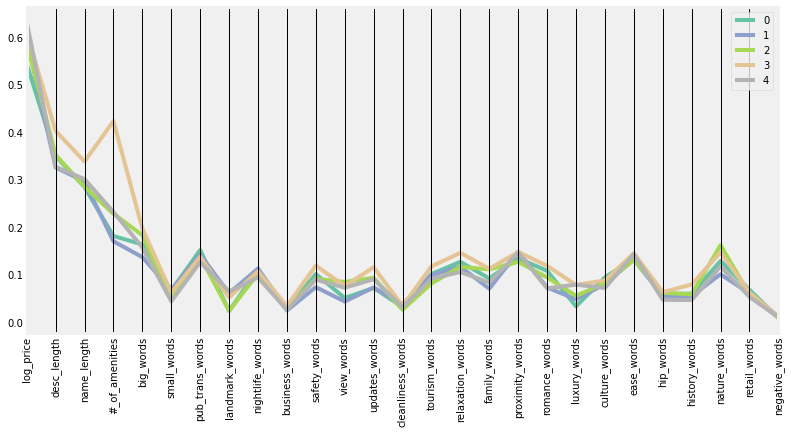

In [238]:
parallel_coordinates(df_text, 'Cluster', colormap=plt.get_cmap("Set2"))
plt.xticks(rotation = 90)
plt.show()

We first look at how the clusters compare to each other in proportion of our different word categories, as well as name and description length. There is not much to be gleaned from this view, other than the following:
- Cluster 3 tends to have a higher number of words in both its property names and property descriptions, as well as a significantly higher average number of amenities.
- Cluster 2 tends to have a lower proportion of public transit words
- Cluster 3 has a slightly higher proportion of both history words and relaxation words
- Word types with the widest distribution between clusters are big words, safety words, luxury words, and nature words.

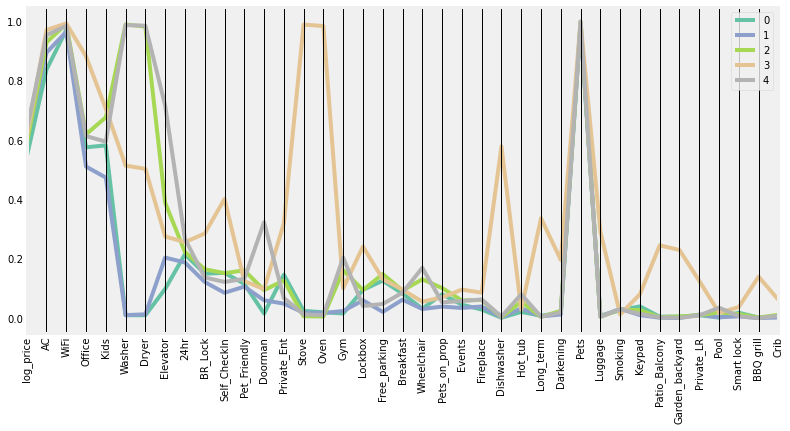

In [239]:
parallel_coordinates(df_amenities, 'Cluster', colormap=plt.get_cmap("Set2"))
plt.xticks(rotation = 90)
plt.show()

Next, we look at how the clusters differ in relation to the list of most common amenities. Some takeaways:
- Cluster 3 is significantly more likely to have an oven, stove, and dishwasher vs. the other clusters.
- Clusters 2 and 4 are much more likely to have a washer and dryer.
- Cluster 3 also has a much higher likelihood of providing self-checkin.
- Cluster 3 most likely to have outdoor amenities like patio/balcony, garden/backyard, and BBQ Grill.
- Pets, pool, and 24hr check-in are the only amenities with approximately no separation between clusters.
- Cluster 4 is most likely to have an on-site gym, elevator, doorman, and wheelchair access.
- Cluster 0 is the least likely to have a doorman.

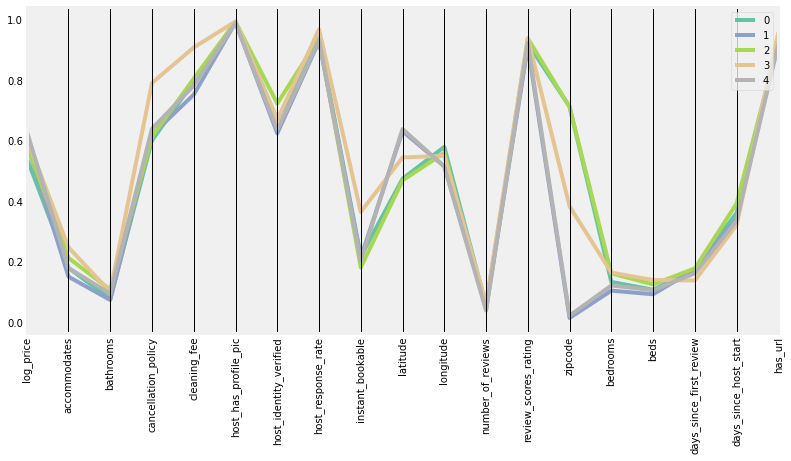

In [240]:
parallel_coordinates(df_base, 'Cluster', colormap=plt.get_cmap("Set2"))
plt.xticks(rotation = 90)
plt.show()

The last group of features is the "base features" listed in the dataset, separate from the extracted features from the amenities and description columns. Of note:
- Cluster 3 tends to have a slightly higher number of beds and bedrooms.
- Zip Code results seem to imply that clusters 0&2 and clusters 1&4 are geographically similar pairs, while cluster 3 stands on its own. The latitude and longitude results support this interpretation as well.
- There's no discernible difference in number of reviews, average rating, or host picture availability across clusters.
- Cluster 3 tends to accommodate the most guests, cluster 1 the fewest.
- Cluster 3 has a notably more strict cancellation policy on average, and is more likely to require a cleaning fee.
- Cluster 2 has a slightly higher likelihood of its host's identity being verified.


In [169]:
scaled_df.to_csv('D:/Springboard/ThirdCapstone/RawData/scaled_df_clusters.csv', index=False)

An important piece of interpreting the results of any machine learning effort is understanding which features had the largest impact on the output of the model. In this case, we ran Principal Component Analysis, which "anonymizes" the data by creating a specified number of PCs that are all linear combinations of the original features. Luckily the PCA library has built-in functionality that allows us to work backwards to determine which features played the largest role.

First, we create a table listing the top feature importance (largest coefficient, in other words) for each of the 25 principal components that we created.

In [225]:
np.set_printoptions(suppress=True, formatter={'float_kind':'{:f}'.format})
variance = pca.explained_variance_ratio_
np.savetxt('D:/Springboard/ThirdCapstone/RawData/var.csv', variance, delimiter=",")

In [226]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on each PCA component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = scaled_df.columns.values.tolist()
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

df_FI = pd.DataFrame(dic.items())
df_FI

,0,1
0,PC0,borough_Manhattan
1,PC1,Washer
2,PC2,Office
3,PC3,host_identity_verified
4,PC4,Kids
5,PC5,Office
6,PC6,host_identity_verified
7,PC7,Elevator
8,PC8,instant_bookable
9,PC9,24hr


In [227]:
components = abs(pca.components_)
np.savetxt('D:/Springboard/ThirdCapstone/RawData/comp.csv', components, delimiter=",")

In [228]:
variance

array([0.125271, 0.106758, 0.075120, 0.054462, 0.045478, 0.041895,
       0.034632, 0.033262, 0.031412, 0.029223, 0.025806, 0.023019,
       0.022323, 0.020474, 0.020372, 0.016317, 0.015552, 0.015028,
       0.013735, 0.012844, 0.012740, 0.011533, 0.011069, 0.010136,
       0.010021])

Now we've created a list of lists called components wherein each of the 25 lists contains all of the feature weights for 1 of the 25 principal components. We also have another list called variance that contains the % of variance explained by each of the 25 pcs. In order to get back to a sorted list of overall feature importances, we need to perform matrix multiplication between these two arrays and then sort them by highest overall importance. 

In [229]:
components

array([[0.038264, 0.011325, 0.003276, ..., 0.494621, 0.050559, 0.002606],
       [0.011860, 0.046539, 0.018671, ..., 0.324739, 0.005703, 0.002062],
       [0.018645, 0.055581, 0.003470, ..., 0.202094, 0.004717, 0.005447],
       ...,
       [0.032687, 0.073144, 0.012563, ..., 0.008075, 0.010305, 0.011236],
       [0.006314, 0.035996, 0.008844, ..., 0.024488, 0.018719, 0.008658],
       [0.111684, 0.211310, 0.088253, ..., 0.006622, 0.028410, 0.008806]])

In [231]:
wt_array = components * variance[:, None]
np.savetxt('D:/Springboard/ThirdCapstone/RawData/wt_array.csv', wt_array, delimiter=",")

In [234]:
d_wt_array = list(map(sum, zip(*wt_array)))
np.savetxt('D:/Springboard/ThirdCapstone/RawData/d_wt_array.csv', d_wt_array, delimiter=",")

In [237]:
data_tuples = list(zip(col_list,d_wt_array))
Feat_Imp = pd.DataFrame(data_tuples, columns=['Feature','Relative_Importance']).sort_values('Relative_Importance', ascending=False)
Feat_Imp.head(25)

,Feature,Relative_Importance
23,Elevator,0.150971
19,Office,0.141951
90,borough_Brooklyn,0.141315
91,borough_Manhattan,0.136932
21,Washer,0.135820
22,Dryer,0.135204
20,Kids,0.123919
24,24hr,0.118754
5,cleaning_fee,0.116036
4,cancellation_policy,0.113256


Based on this analysis Elevator and Office (amenities), borough_Brooklyn and borough_Manhattan (borough flags), and Washer/Dryer (amenities) were the largest differentiators when determining cluster membership. It's worth noting, however, that this appears to be a fairly shallow distribution. The top 11 features only range between .151 and .113 in relative importance, and the full top 25 is above 0.05.

We'll take a deeper dive into cluster classification and labeling in the final report notebook for this project.